In [1]:
import sys,os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import cmocean.cm as cmo
from scipy.interpolate import RegularGridInterpolator


import netCDF4 as nc
import requests
import math
import io
import re
from pandas.plotting import register_matplotlib_converters

import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def deg_to_card(d):
    dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ix = round(d / (360. / len(dirs)))
    return dirs[ix % len(dirs)]

In /home/sebastien/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sebastien/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sebastien/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/sebastien/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sebastien/.local/lib/python3.6/site-packages/matplo

In [2]:
# Load Joao's model data

model = xr.open_dataset('/net/datastor1/data/ocean/Moana/NZB/moana_backboneV2/his/nz5km_his_199301.nc')
model_h = model['h']
model_lon = model['lon_rho']
model_lat = model['lat_rho']

In [21]:
# Stations set 1
lats = np.array([-37.5, -37.5, -37.5, -37.5, -38, -38, -38, -38, -38.5, -38.5, -38.5, -38.5, -38.75, -38.75, -38.75, -38.75])
lons = np.array([173.5, 174, 174.25, 174.5, 173.5, 174, 174.25, 174.5, 173.5, 174, 174.25, 174.5, 173.5, 174, 174.25,174.5])

raglan_lat = -37.80456 
raglan_lon = 174.86558

/home/sebastien/.local/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


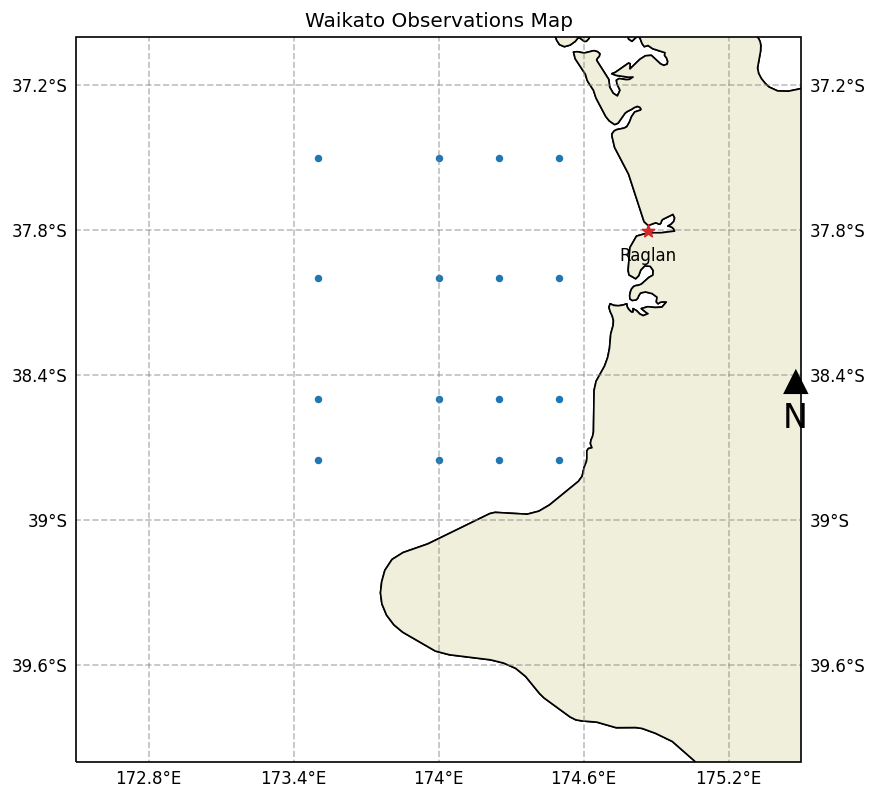

In [22]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [172.5, 175.5, -40, -37.]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

# plot bathymetry

levels = [100,500,1000,2000,3000,4000,5000,6000,7000]
#cmap = cmo.tools.lighten(cmo.deep, 0.25)
cmap = cmo.deep

ms = 12
marker = 'o'
dot_mpi = ax.scatter(lons+lon_offset,lats,s=ms,c='tab:blue',marker=marker)


# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Waikato Observations Map')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
#gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,0.5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(raglan_lon+lon_offset,raglan_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(raglan_lon, raglan_lat-0.1, 'Raglan', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=101)
ax.set_ylabel('Latitude')
left = 175.5
bottom = -38.5
ax.quiver(left+lon_offset,bottom, 0, 1)
ax.set_ylabel('Latitude')

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)

plt.show()

In [35]:
model = xr.open_dataset('/net/datastor1/data/ocean/Moana/NZB/moana_backboneV2/clim/monthly/MEAN_NZ.nc')
model = xr.open_dataset('/net/datastor1/data/ocean/Moana/NZB/moana_backboneV2/clim/monthly/MEAN_NZ_Aug.nc')

In [36]:
lev = 49
res = 35

v = model['v'][0,lev,:,:]
u = model['u'][0,lev,:,:]
lon_u = model['lon_u'][0,:]
lat_u = model['lat_u'][:,0]
lon_v = model['lon_v'][0,:]
lat_v = model['lat_v'][:,0]
temp = model['temp'][0,lev,:,:]
lon_t = model['lon_rho'][0,:]
lat_t = model['lat_rho'][:,0]

box = [172.5, 175.5, -40, -37.]

lonnew = np.linspace(box[0],box[1],res)
latnew = np.linspace(box[2],box[3],res)

u2 = np.empty((len(lonnew),len(latnew)))
v2 = np.empty((len(lonnew),len(latnew)))

#vals = np.argsort(lon_u)
#lon_u = lon_u[vals]
#u = u[vals,:]
#vals = np.argsort(lon_v)
#lon_v = lon_v[vals]
#v = v[vals,:]


vf = RegularGridInterpolator((lon_v,lat_v),v.transpose())
uf = RegularGridInterpolator((lon_u,lat_u),u.transpose())
tf = RegularGridInterpolator((lon_t,lat_t),temp.transpose()) 
        
for ii in range(len(lonnew)):
    for jj in range(len(latnew)):
        u2[ii,jj] = uf([lonnew[ii], latnew[jj]])  
        v2[ii,jj] = vf([lonnew[ii], latnew[jj]])    
        
u2 = u2.transpose()
v2 = v2.transpose()

mag = np.empty(len(lats))
angle = []
obt = np.empty(len(lats))

for ii in range(len(lats)):
    u = uf([lons[ii],lats[ii]])
    v = vf([lons[ii],lats[ii]])
    mag[ii] = np.round((u**2+v**2)**(1/2)*100,0)
    angle.append(deg_to_card(math.atan2(v,u)*180/np.pi-90))
    val = np.round(tf([lons[ii],lats[ii]]),1)
    obt[ii] = np.round(val*2,0)/2
    
angle2 = ['SE','S','S','SE','E','N','SE','SE','ESE','E','N','WNW','SW','N','E','SE','E','E','NE']
lats2 = np. array(['{}\xb0S'.format(abs(lat)) for lat in lats])   
lons2 = np. array(['{}\xb0E'.format(abs(lon)) for lon in lons]) 
df = pd.DataFrame({'Latitude':lats2, 'Longitude':lons2,'Current Speed (cm/s)':mag,'Current Direction':angle,'Temperature (degC)':obt})
df.index_name = "Station Number"

df2 = pd.DataFrame({'Latitude':lats, 'Longitude':lons,'Temperature (degC)':obt})
df2.index_name = "Station Number"

In [37]:
df.sort_values(by=['Latitude'])

,Latitude,Longitude,Current Speed (cm/s),Current Direction,Temperature (degC)
0,37.5°S,173.5°E,2.0,WNW,14.0
1,37.5°S,174.0°E,9.0,NNW,14.0
2,37.5°S,174.25°E,6.0,N,13.5
3,37.5°S,174.5°E,4.0,NNW,13.5
4,38.0°S,173.5°E,5.0,WNW,14.0
5,38.0°S,174.0°E,7.0,NNW,13.5
6,38.0°S,174.25°E,5.0,N,13.5
7,38.0°S,174.5°E,4.0,NW,13.0
8,38.5°S,173.5°E,3.0,WNW,13.5
9,38.5°S,174.0°E,7.0,NNW,13.5


/home/sebastien/.local/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


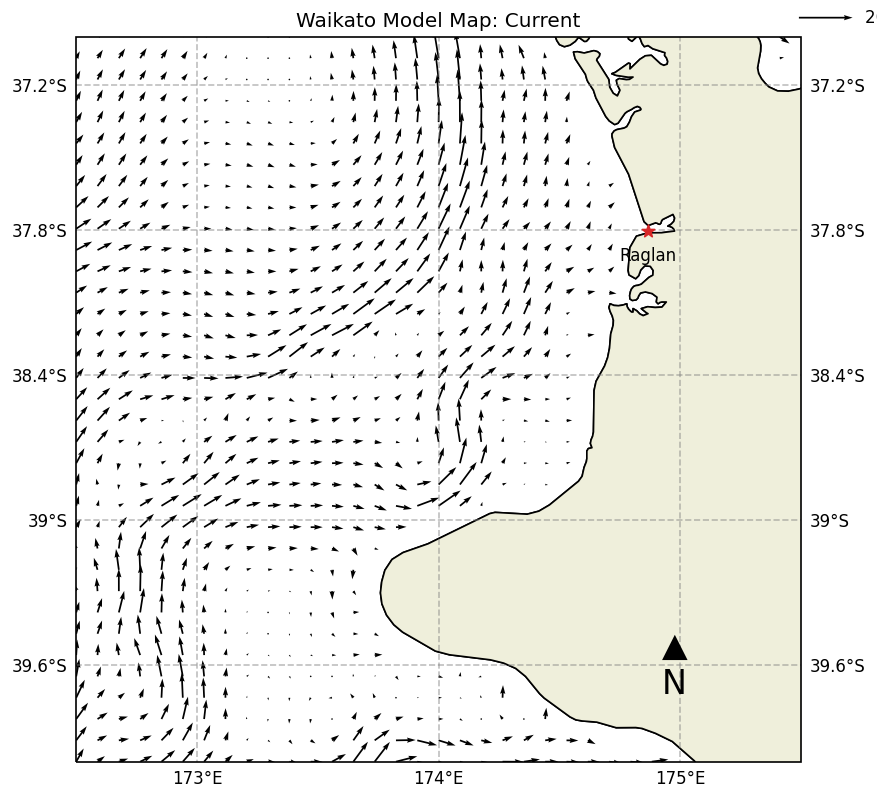

In [38]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [172.5, 175.5, -40, -37.]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'

Q = ax.quiver(lonnew+lon_offset,latnew,u2*100,v2*100)
qk = ax.quiverkey(Q, 0.8, 0.9, 20, r'20 cm/s', labelpos='E',zorder=106,coordinates='figure')

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Waikato Model Map: Current')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(raglan_lon+lon_offset,raglan_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(raglan_lon, raglan_lat-0.1, 'Raglan', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())
left = 175.
bottom = -39.6
ax.quiver(left+lon_offset,bottom, 0, 1)


# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()

/home/sebastien/.local/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


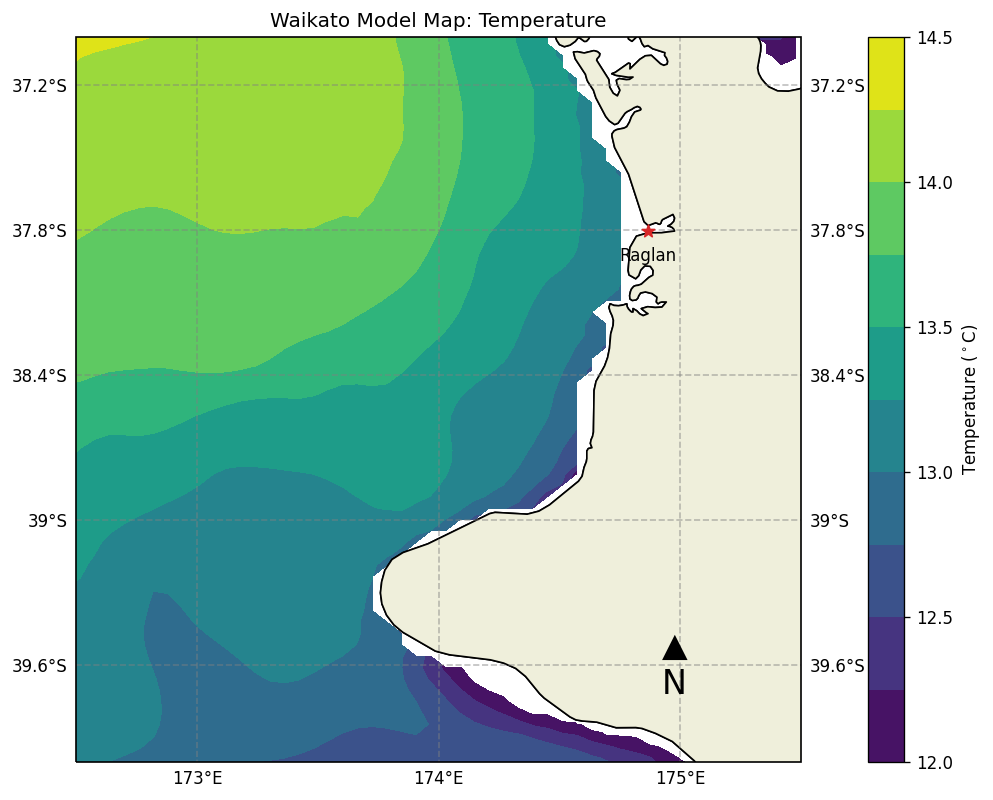

In [44]:
lev = 49

temp = model['temp'][0,lev,:,:]
lon_t = model['lon_rho'][0,:]
lat_t = model['lat_rho'][:,0]

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [172.5, 175.5, -40, -37.]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'
levels = np.linspace(12.,14.5,11)
sm = ax.contourf(lon_t+lon_offset,lat_t,temp,levels=levels)
cb = plt.colorbar(sm, ax=ax, orientation="vertical",fraction=0.046, pad=0.06)
cb.set_label("Temperature ($^\circ$C)")

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Waikato Model Map: Temperature')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(raglan_lon+lon_offset,raglan_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(raglan_lon, raglan_lat-0.1, 'Raglan', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

left = 175.
bottom = -39.6
ax.quiver(left+lon_offset,bottom, 0, 1)

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()

/home/sebastien/.local/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


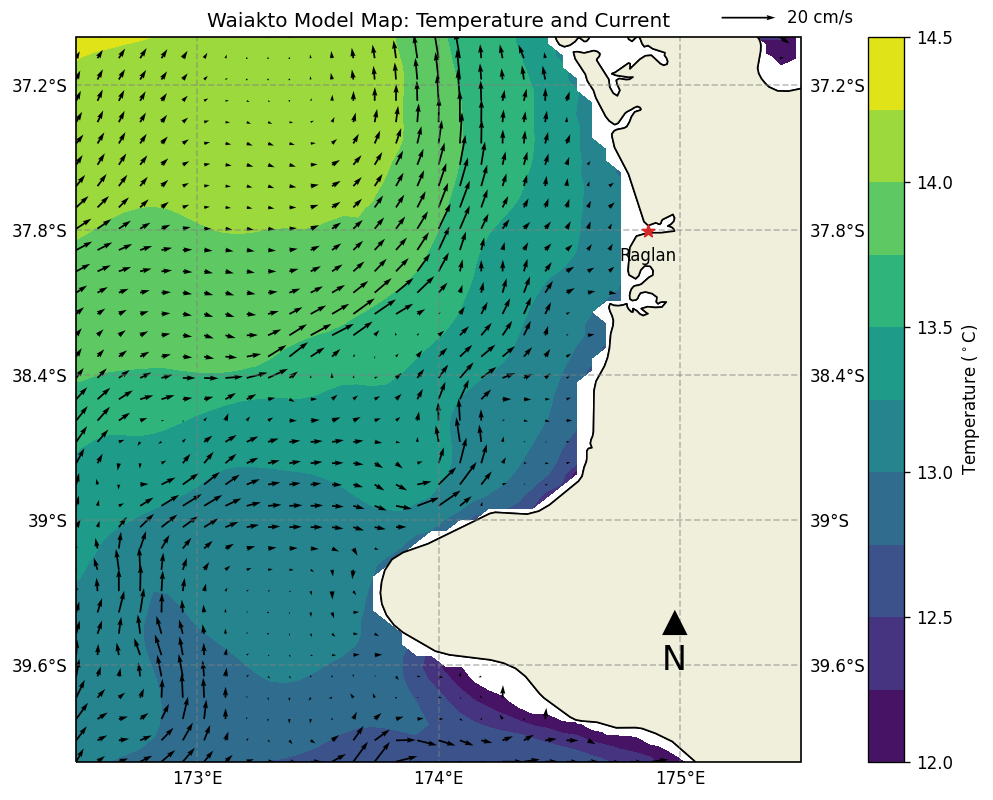

In [45]:

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [172.5, 175.5, -40, -37.]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'
levels = np.linspace(12.,14.5,11)
sm = ax.contourf(lon_t+lon_offset,lat_t,temp,levels=levels)
cb = plt.colorbar(sm, ax=ax, orientation="vertical",fraction=0.046, pad=0.06)
cb.set_label("Temperature ($^\circ$C)")

Q=ax.quiver(lonnew+lon_offset,latnew,u2*100,v2*100)
qk = ax.quiverkey(Q, 0.8, 0.9, 20, r'20 cm/s', labelpos='E',zorder=106,coordinates='figure')

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Waiakto Model Map: Temperature and Current')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(raglan_lon+lon_offset,raglan_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(raglan_lon, raglan_lat-0.1, 'Raglan', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

left = 175.
bottom = -39.5
ax.quiver(left+lon_offset,bottom, 0, 1)

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()